In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix

import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import torch

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from wordcloud import WordCloud
seed = 12345

In [2]:
def get_clusters(seed):
    random.seed(seed)
    return graph.community_multilevel(weights='cosine')

def get_topic_vec(cluster, weight=True):
    mask = np.zeros(num_words, dtype=bool)
    mask[cluster] = True
    if not weight:
        return mask
    else:
        topic_vec = np.zeros(num_words)
        topic_vec[mask] = [word2weight[word] for word in m.columns[cluster]]
        return topic_vec
    
def get_matching_score(matrix, num_pairs=None, return_idx=False):
    
    """
    return the mean of greedily-searched best matching pairs between old and new topic vectors 
    based on max cos-similarity
    """
    
    if not num_pairs:
        num_pairs = min(matrix.shape)
        
    max_values, max_value_indices = [], []
    for _ in range(num_pairs):
        max_value_idx = np.unravel_index(np.argmax(matrix), matrix.shape)
        max_value = matrix[max_value_idx]
        max_values.append(max_value)
        matrix[max_value_idx[0], :] = -np.inf
        matrix[:, max_value_idx[1]] = -np.inf
        if return_idx:
            max_value_indices.append(max_value_idx)

    return max_values, max_value_indices

In [10]:
var_list = ['Co', 'Gom', 'Env', 'Epg', 'Bbl', 'Rpc', 'Ep']

def plot_topic_wordclouds(word_weights, ncols=2, topic_names=var_list):
    nrows = int(np.ceil(len(word_weights)/ncols))
    fig, ax = plt.subplots(figsize=(12,24), nrows=nrows, ncols=ncols)
    for i, (w, topic) in enumerate(zip(word_weights, topic_names)):
        wordcloud = WordCloud(width = 400, height = 400,
                          background_color ='white',
                          random_state=seed).generate_from_frequencies(w)
        ax[int(i/ncols)][i%ncols].imshow(wordcloud)
        ax[int(i/ncols)][i%ncols].axis('off')
        ax[int(i/ncols)][i%ncols].set_title(topic)
    
    # hide the last ax
    ax[-1, -1].set_visible(False)
    
def get_word_weights(c):
    topic_vec = [get_topic_vec(cluster) for cluster in c]
    cs = cosine_similarity(topic_vec_old, topic_vec)
    _, old2new = get_matching_score(cs, return_idx=True)

    assert len(old2new) == n_topics_old
    word_weights = list(range(len(old2new)))
    for old, new in old2new:
        word_weights[old] = {k: v for k, v in zip(m.columns, topic_vec[new])}
    return word_weights

In [4]:
def expand_membership(membership_new_387):
    membership_new = []
    for i in range(len(df)):
        if i in idx_387:
            membership_new.append(membership_new_387.pop(0))
        else:
            membership_new.append(n_topics_old)

    assert len(membership_new) == 441
    assert not membership_new_387
    return membership_new

def allocate_remainings(membership_new, n_epoch=20):
    m['_cluster'] = membership_new
    graph_441 = ig.Graph.Weighted_Adjacency(m.iloc[:,:-1].values, 
                                                        mode='undirected', attr='cosine', loops=False)
    best_mod = graph_441.modularity(membership_new, weights='cosine')
    best_mod_list = []

    for s in tqdm(range(n_epoch)):
        m_shuffled = m.sample(frac=1, random_state=s)
        for word, cluster in m_shuffled['_cluster'].items():
            if cluster == n_topics_old:
                current_mod_list = []
                for i in range(n_topics_old):
                    m_shuffled['_cluster'][word] = i
                    graph_441 = ig.Graph.Weighted_Adjacency(m_shuffled.reindex(columns=m_shuffled.index).values, 
                                                            mode='undirected', attr='cosine', loops=False)
                    current_mod_list.append(graph_441.modularity(m_shuffled['_cluster'], weights='cosine'))
                m_shuffled['_cluster'][word] = np.argmax(current_mod_list)

        current_best_mod = max(current_mod_list)
        if current_best_mod > best_mod:
            best_mod = current_best_mod
            print(f'updated best mod: {best_mod}')
            best_membership = m_shuffled.loc[m.index]['_cluster'].values
        best_mod_list.append(best_mod)
    return best_membership, best_mod_list

In [5]:
m = pd.read_csv("/shared/share_mamaysky-glasserman/energy_drivers/2023/DataProcessing/cosine/cosine.csv", 
                 header=0, index_col=0)
num_words = len(m.columns)
assert num_words == 441

words_387 = pd.read_excel('2018-05-04 energy word grouping 387 words.xlsx')['Word'].to_list()

df = pd.read_csv('clustering_C.csv')
idx_387 = [m.columns.to_list().index(word) for word in words_387]
old_topics = df.iloc[idx_387]['Topic'].to_list()
n_topics_old = max(old_topics)

dtmPath = '/shared/share_mamaysky-glasserman/energy_drivers/2023/DataProcessing/concat/dtm_concatenate.npz'
dtm = sparse.load_npz(dtmPath)
weights = np.array(dtm.sum(axis=0)/dtm.sum())[0]
word2weight = {k: v for k, v in zip(m.columns, weights)}
word_weights_387 = [word2weight[word] for word in words_387]

old = (1 - df.pivot_table(index='word', columns='Topic').isna().loc[m.columns]).values.T
membership_old = (df.set_index('word').loc[m.columns]['Topic'] - 1).to_list()
membership_old_387 = [membership_old[i] for i in idx_387]

arr = np.where(old == 1)
clusters_old = [arr[1][np.where(arr[0] == i)] for i in range(n_topics_old)]
topic_vec_old = [get_topic_vec(cluster) for cluster in clusters_old]

graph = ig.Graph.Weighted_Adjacency(m.iloc[idx_387,idx_387].values, mode='undirected', attr='cosine', loops=False)

In [5]:
# res = {}
# res['size'], res['mod'], res['cs'], res['acc'] = [], [], [], []

# for s in tqdm(range(seed)):
    
#     c = get_clusters(s)
#     res['size'].append(len(c.sizes()))
#     res['mod'].append(c.modularity)
 
#     topic_vec = [get_topic_vec(cluster) for cluster in c]
#     cs_matrix = cosine_similarity(topic_vec_old, topic_vec)
#     cs_list, old2new = get_matching_score(cs_matrix, return_idx=True)
#     res['cs'].append(np.mean(cs_list))
    
    
#     new2old = {new:old for old, new in old2new}
#     membership_new_387 = [new2old.get(new,n_topics_old) for new in c.membership]
#     res['acc'].append(accuracy_score(membership_old_387, membership_new_387, sample_weight=word_weights_387))
    
# torch.save(res, 'res_weighted_acc.pt')

100%|█████████████████████████████████████| 12345/12345 [06:50<00:00, 30.05it/s]


In [6]:
res = torch.load('res_weighted_acc.pt')
idx_7topics = [i for i,s in enumerate(res['size']) if s==n_topics_old]
mod_7 = [res['mod'][i] for i in idx_7topics]
acc_7 = [res['acc'][i] for i in idx_7topics]
cs_7 = [res['cs'][i] for i in idx_7topics]

best_seed = {}
mod_percentile = np.percentile(mod_7, 99, method='nearest')
best_seed['mod'] = res['mod'].index(mod_percentile)
best_seed['acc'] = res['acc'].index(max(acc_7))
best_seed['cs'] = res['cs'].index(max(cs_7))
best_seed # {'mod': 261, 'acc': 5058, 'cs': 682}

{'mod': 261, 'acc': 5058, 'cs': 682}

create two sets of topic allocations: closest and highest modularity
weighted accuracy score => word cloud to look similar
include 54 words greedily
99 percentile of best modularity
closest modularity
send 2 text series

***mod***


  5%|██▏                                         | 1/20 [00:05<01:36,  5.06s/it]

updated best mod: 0.4251869940963904


 10%|████▍                                       | 2/20 [00:10<01:31,  5.07s/it]

updated best mod: 0.4256213122781522


 15%|██████▌                                     | 3/20 [00:15<01:26,  5.06s/it]

updated best mod: 0.4259647360074634


 50%|█████████████████████▌                     | 10/20 [00:50<00:50,  5.01s/it]

updated best mod: 0.4264760907494415


100%|███████████████████████████████████████████| 20/20 [01:40<00:00,  5.05s/it]


***acc***


  5%|██▏                                         | 1/20 [00:05<01:39,  5.24s/it]

updated best mod: 0.4248578097176718


 15%|██████▌                                     | 3/20 [00:15<01:29,  5.26s/it]

updated best mod: 0.4248578097176742


100%|███████████████████████████████████████████| 20/20 [01:45<00:00,  5.29s/it]


***cs***


  5%|██▏                                         | 1/20 [00:05<01:38,  5.17s/it]

updated best mod: 0.42419772088141267


 15%|██████▌                                     | 3/20 [00:15<01:26,  5.11s/it]

updated best mod: 0.42419772088141516


100%|███████████████████████████████████████████| 20/20 [01:42<00:00,  5.11s/it]


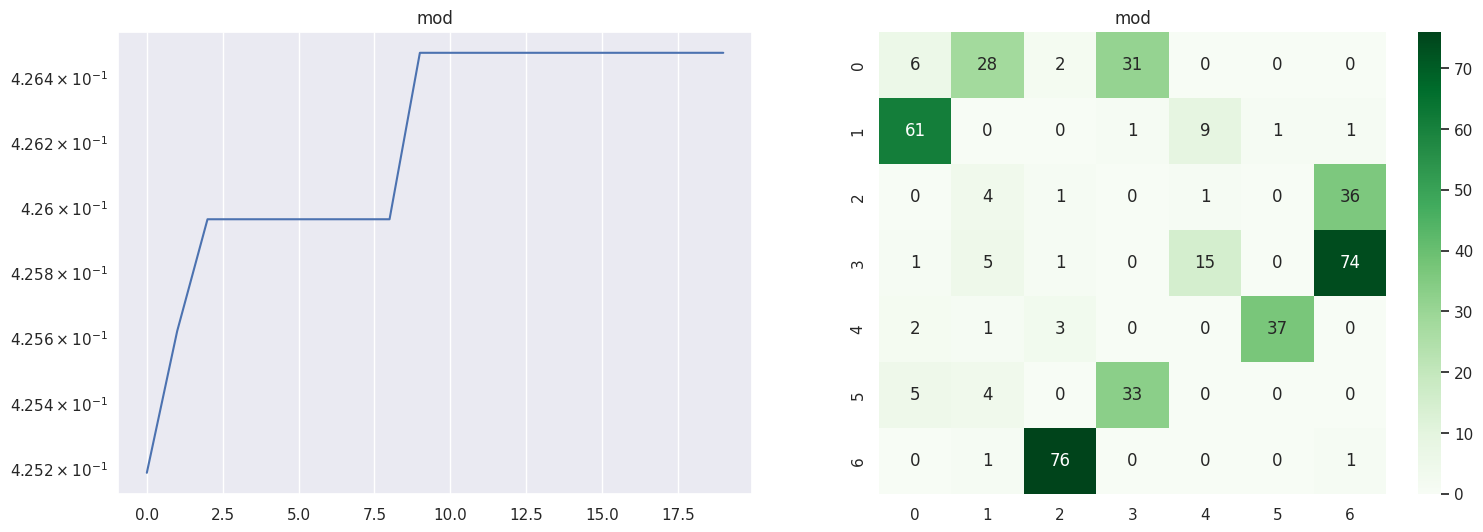

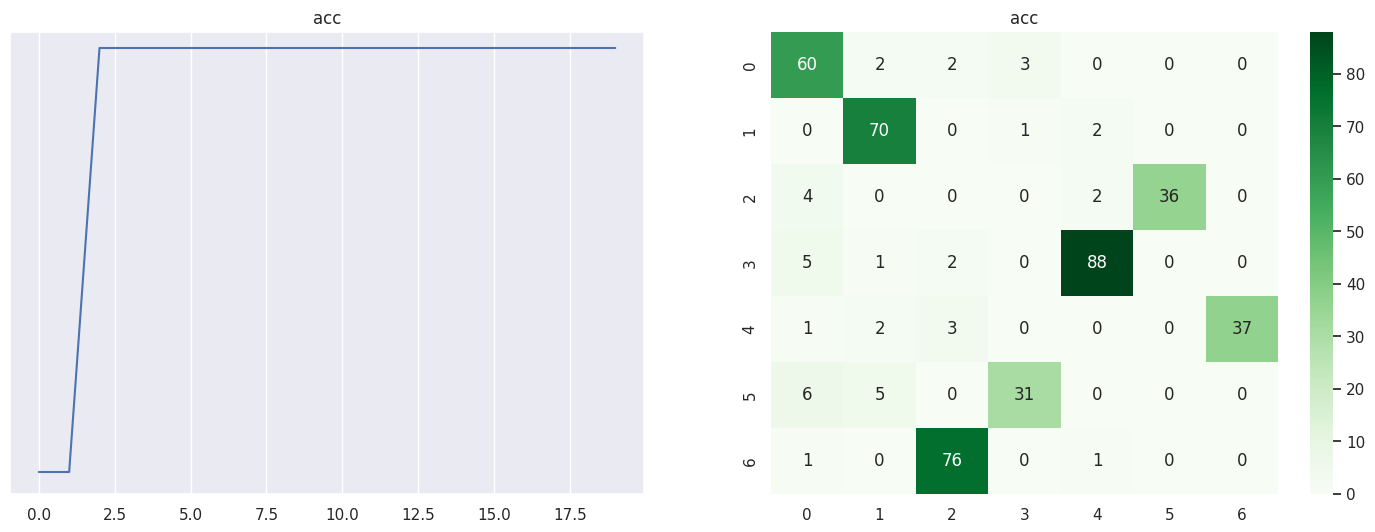

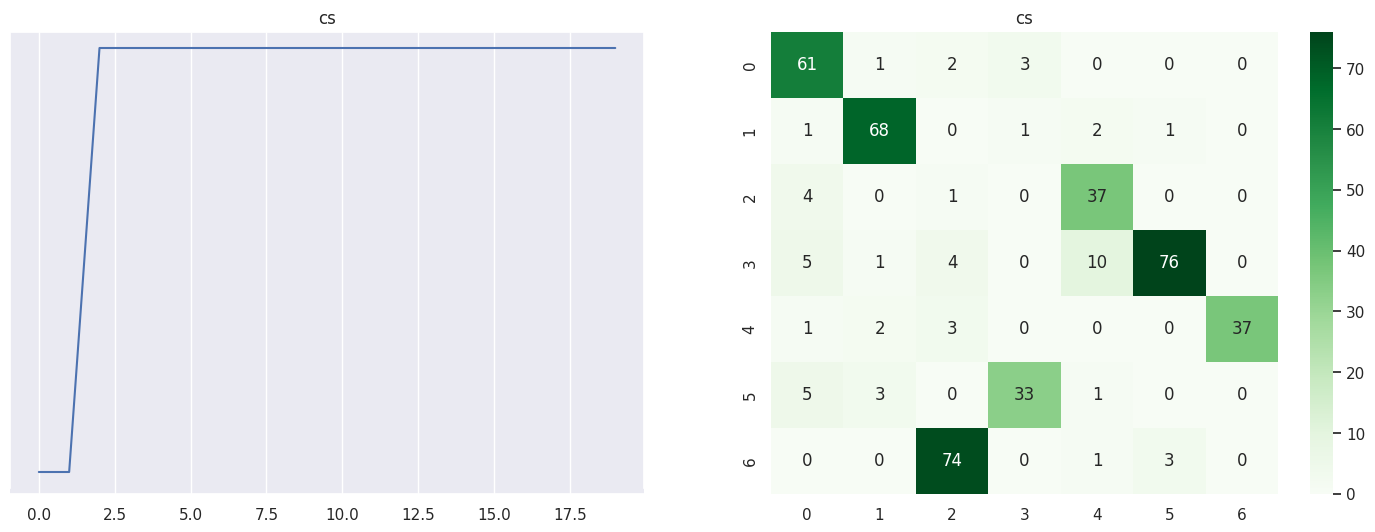

In [7]:
res_best = {}
for metric, s in best_seed.items():
    c = get_clusters(s)
    print(f'***{metric}***')
    membership_new = expand_membership(c.membership)
    res_best[metric], best_mod_list = allocate_remainings(membership_new)
    
    fig, ax = plt.subplots(figsize=(18,6), nrows=1, ncols=2)
    ax[0].plot(best_mod_list)
    ax[0].set_yscale('log')
    ax[0].set_title(metric)
    sns.heatmap(confusion_matrix(membership_old, res_best[metric]), cmap='Greens', annot=True, ax=ax[1])
    ax[1].set_title(metric);

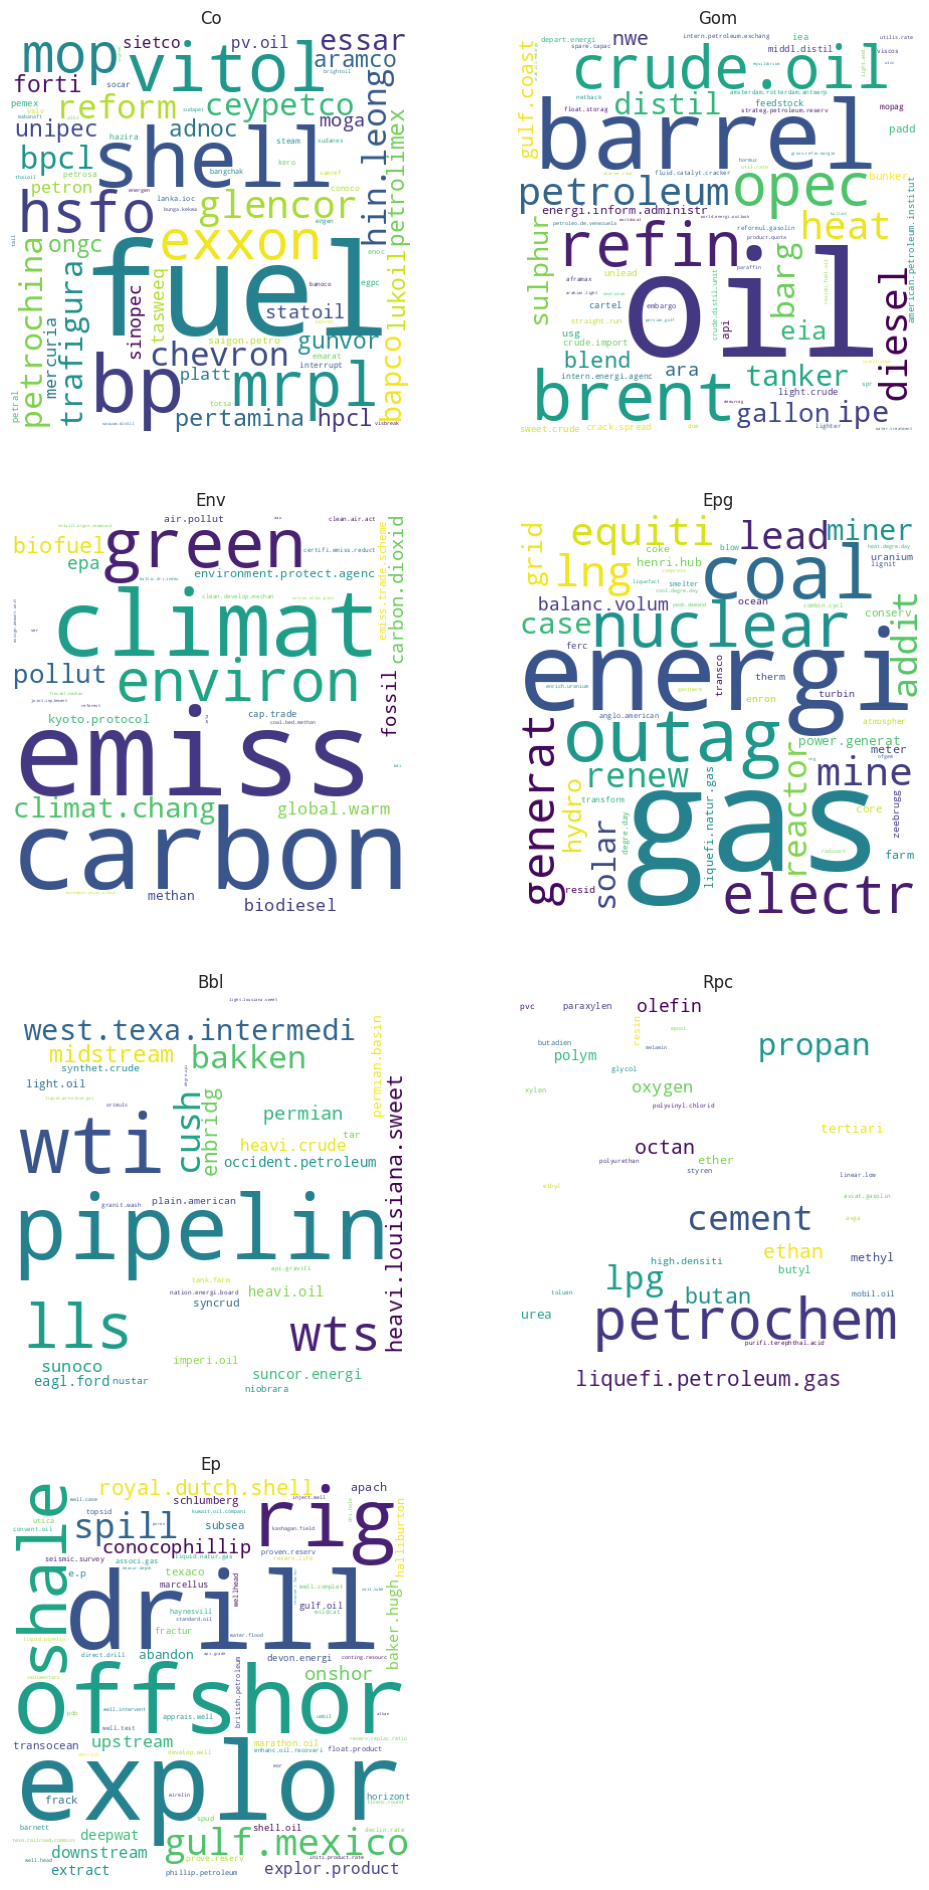

In [16]:
c = [np.where(res_best['acc']==i)[0] for i in range(n_topics_old)]
plot_topic_wordclouds(get_word_weights(c))
plt.savefig('clouds best acc.pdf')

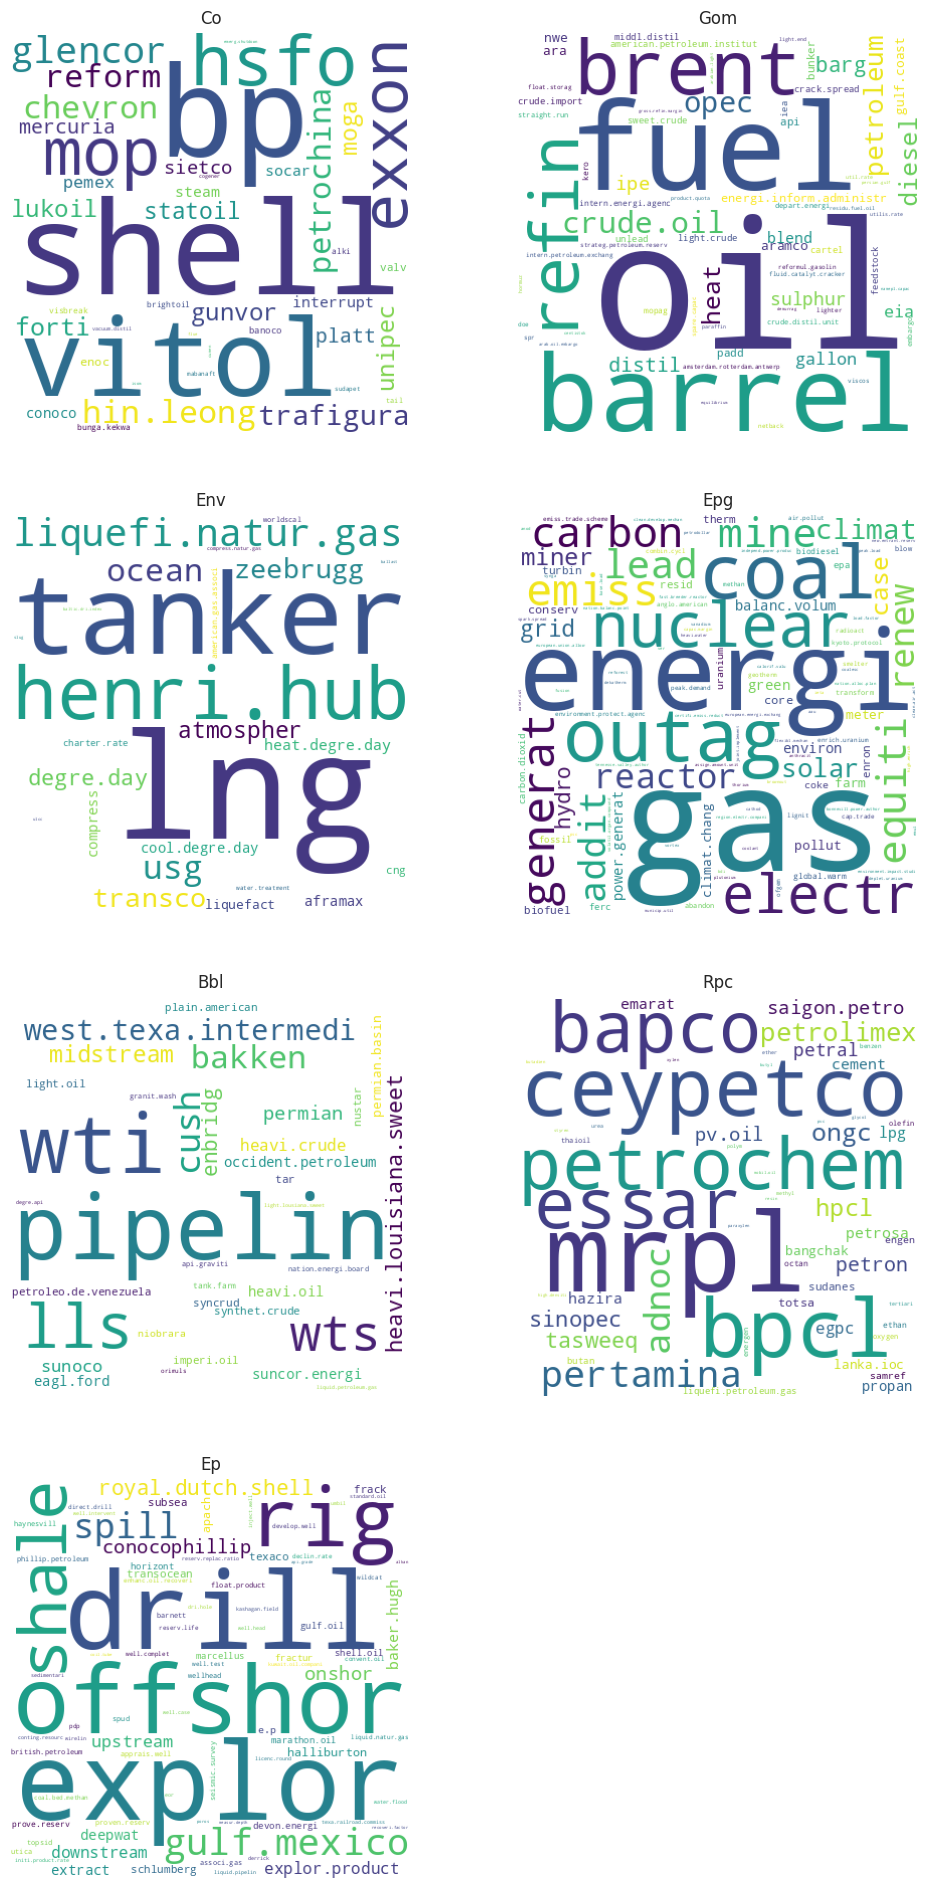

In [17]:
c = [np.where(res_best['mod']==i)[0] for i in range(n_topics_old)]
plot_topic_wordclouds(get_word_weights(c))
plt.savefig('clouds best mod.pdf')

In [47]:
def save_cluster_df(df, metric='acc'):
    df['freq'] = np.array(dtm.sum(axis=0))[0]
    df['Topic'] = res_best[metric]+1
    df = df.sort_values(['Topic', 'freq'], ascending=[True, False])
    df.to_csv(f'clustering_C_{metric}.csv', index=False)
    return df

In [48]:
save_cluster_df(df, metric='acc')

,word,Topic,freq
0,fuel,1,1634275
2,shell,1,437839
1,bp,1,413288
3,vitol,1,286592
4,mrpl,1,234780
...,...,...,...
314,liquid.petroleum.gas,7,511
315,degre.api,7,460
317,sagd,7,168
318,cetan,7,133


In [49]:
save_cluster_df(df, metric='mod')

,word,Topic,freq
67,oil,1,4589937
0,fuel,1,1634275
68,barrel,1,1352220
69,brent,1,586493
71,refin,1,465014
...,...,...,...
181,coalesc,7,162
273,region.electr.compani,7,160
179,new.entrant.reserv,7,150
276,deplet.uranium,7,125
